# Importing

In [8]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi
from sklearn import preprocessing


# Datasets Preparation

In [9]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, date, mask)


# Masking

In [10]:
def masking (depth, temp, saline, mask):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)

    return (temp, saline)


# SOM

In [11]:
def som (depth, temp, saline):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1])) 
    inputs2 = inputs[:,indx[:,0]]
    inputs3 = preprocessing.normalize(inputs2, norm= 'max')
    inputs3 = inputs3.transpose()

    # SOM
    temp_som = SOM(m=3, n=2, dim= inputs3[0,:].size)
    temp_som.fit(inputs3, epochs=100)
    predictions = temp_som.predict(inputs3)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2.transpose(), predictions, clusters)


# Printing

In [12]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [13]:
def plotting (depth, clusters, unique):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': temp[0,depth].y, 'x': temp[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    fig, ax = plt.subplots(1, 1, figsize=(5, 9))

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9,                    
                    )
    
    cmap = plt.get_cmap('viridis', int(unique.max()+1))
    cmap.set_bad('gray')

    map.plot.pcolormesh(ax=ax, cmap=cmap, levels= np.concatenate((unique,[unique.size])), cbar_kwargs={'ticks': unique}) 
    sa_vi.set_aspect(ax)
    ax.set_title('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters')

    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig.suptitle('SOM clustering using temperature and salinity for ' + str(date[0].year) + '/' + month + '/' + day)
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 27775 

The minimum temperature for cluster 0 is 6.81 degrees Celsius
The maximum temperature for cluster 0 is 8.94 degrees Celsius
The mean temperature for cluster 0 is 8.0 degrees Celsius 

The minimum salinity for cluster 0 is 27.22 g/kg
The maximum salinity for cluster 0 is 31.32 g/kg
The mean salinity for cluster 0 is 30.27 g/kg 


The amount of grid boxes for cluster 1 is 14872 

The minimum temperature for cluster 1 is 7.99 degrees Celsius
The maximum temperature for cluster 1 is 9.73 degrees Celsius
The mean temperature for cluster 1 is 8.62 degrees Celsius 

The minimum salinity for cluster 1 is 27.3 g/kg
The maximum salinity for cluster 1 is 30.67 g/kg
The mean salinity for cluster 1 is 28.26 g/kg 


The amount of grid boxes for cluster 2 is 5156 

The minimum temperature for cluster 2 is 7.28 degrees Celsius
The maximum temperature for cluster 2 is 8.75 degrees Celsius
The mean temperature for cluster 2 is 8.5 degrees Celsius 

The m

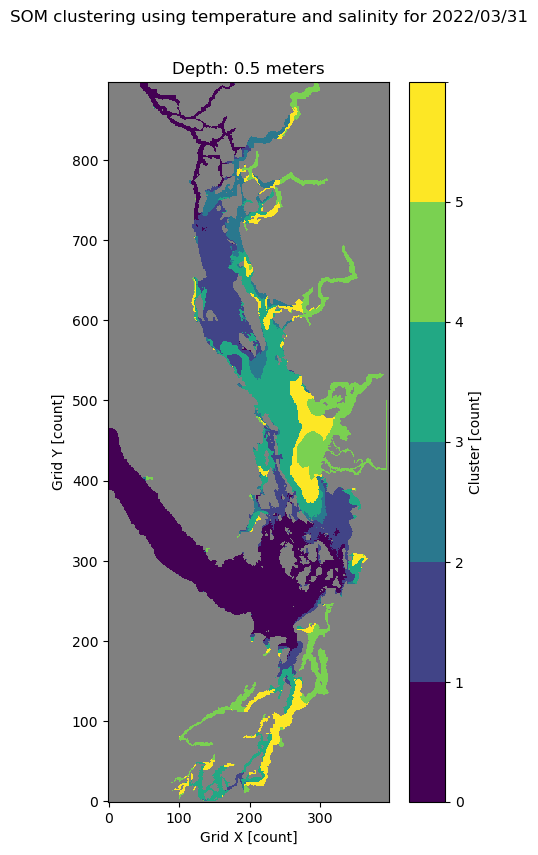

The amount of grid boxes for cluster 0 is 8859 

The minimum temperature for cluster 0 is 7.91 degrees Celsius
The maximum temperature for cluster 0 is 10.54 degrees Celsius
The mean temperature for cluster 0 is 9.22 degrees Celsius 

The minimum salinity for cluster 0 is 23.78 g/kg
The maximum salinity for cluster 0 is 26.95 g/kg
The mean salinity for cluster 0 is 25.23 g/kg 


The amount of grid boxes for cluster 1 is 13052 

The minimum temperature for cluster 1 is 6.25 degrees Celsius
The maximum temperature for cluster 1 is 11.16 degrees Celsius
The mean temperature for cluster 1 is 9.13 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 24.47 g/kg
The mean salinity for cluster 1 is 19.13 g/kg 


The amount of grid boxes for cluster 2 is 12915 

The minimum temperature for cluster 2 is 7.61 degrees Celsius
The maximum temperature for cluster 2 is 9.8 degrees Celsius
The mean temperature for cluster 2 is 8.64 degrees Celsius 

The

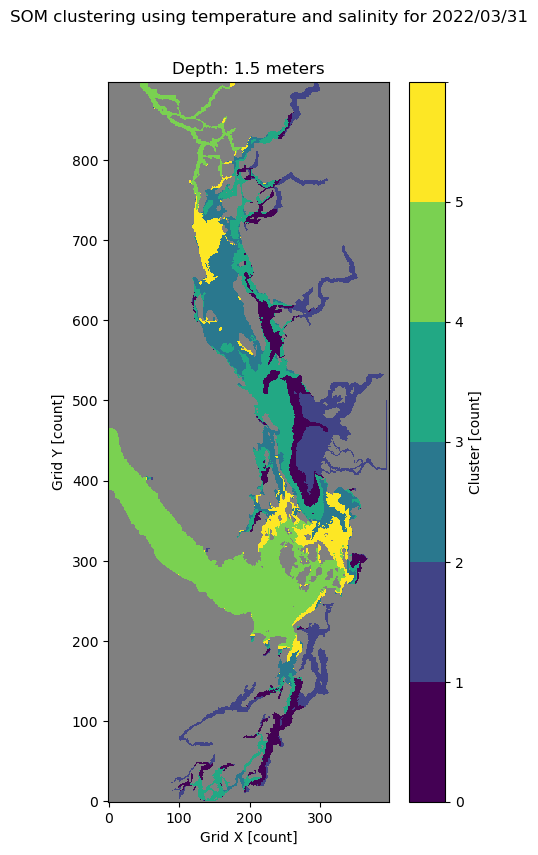

The amount of grid boxes for cluster 0 is 25535 

The minimum temperature for cluster 0 is 6.73 degrees Celsius
The maximum temperature for cluster 0 is 9.16 degrees Celsius
The mean temperature for cluster 0 is 7.96 degrees Celsius 

The minimum salinity for cluster 0 is 28.72 g/kg
The maximum salinity for cluster 0 is 31.32 g/kg
The mean salinity for cluster 0 is 30.41 g/kg 


The amount of grid boxes for cluster 1 is 8093 

The minimum temperature for cluster 1 is 7.48 degrees Celsius
The maximum temperature for cluster 1 is 9.29 degrees Celsius
The mean temperature for cluster 1 is 8.26 degrees Celsius 

The minimum salinity for cluster 1 is 26.75 g/kg
The maximum salinity for cluster 1 is 30.62 g/kg
The mean salinity for cluster 1 is 28.79 g/kg 


The amount of grid boxes for cluster 2 is 14059 

The minimum temperature for cluster 2 is 7.64 degrees Celsius
The maximum temperature for cluster 2 is 9.68 degrees Celsius
The mean temperature for cluster 2 is 8.56 degrees Celsius 

Th

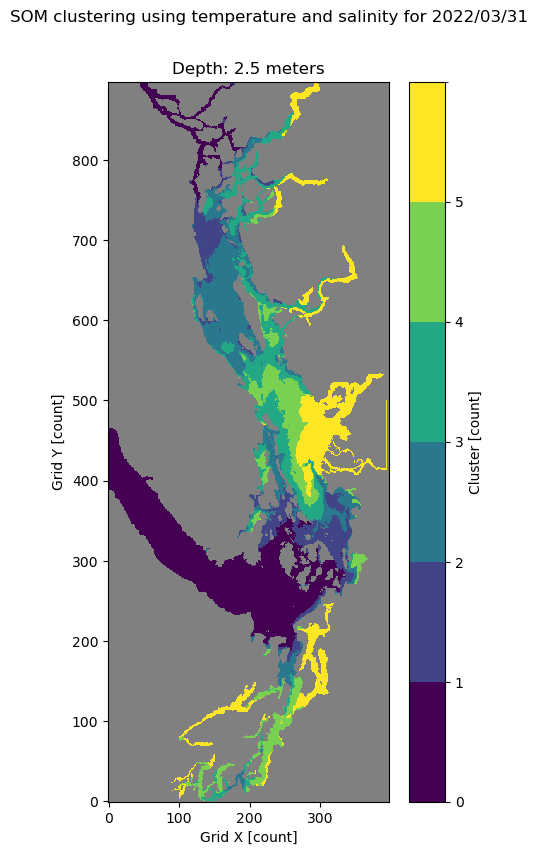

The amount of grid boxes for cluster 0 is 10682 

The minimum temperature for cluster 0 is 8.14 degrees Celsius
The maximum temperature for cluster 0 is 10.52 degrees Celsius
The mean temperature for cluster 0 is 9.12 degrees Celsius 

The minimum salinity for cluster 0 is 23.83 g/kg
The maximum salinity for cluster 0 is 28.42 g/kg
The mean salinity for cluster 0 is 26.15 g/kg 


The amount of grid boxes for cluster 1 is 7807 

The minimum temperature for cluster 1 is 6.25 degrees Celsius
The maximum temperature for cluster 1 is 10.84 degrees Celsius
The mean temperature for cluster 1 is 8.74 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 25.24 g/kg
The mean salinity for cluster 1 is 20.26 g/kg 


The amount of grid boxes for cluster 2 is 15899 

The minimum temperature for cluster 2 is 8.33 degrees Celsius
The maximum temperature for cluster 2 is 9.69 degrees Celsius
The mean temperature for cluster 2 is 8.63 degrees Celsius 

Th

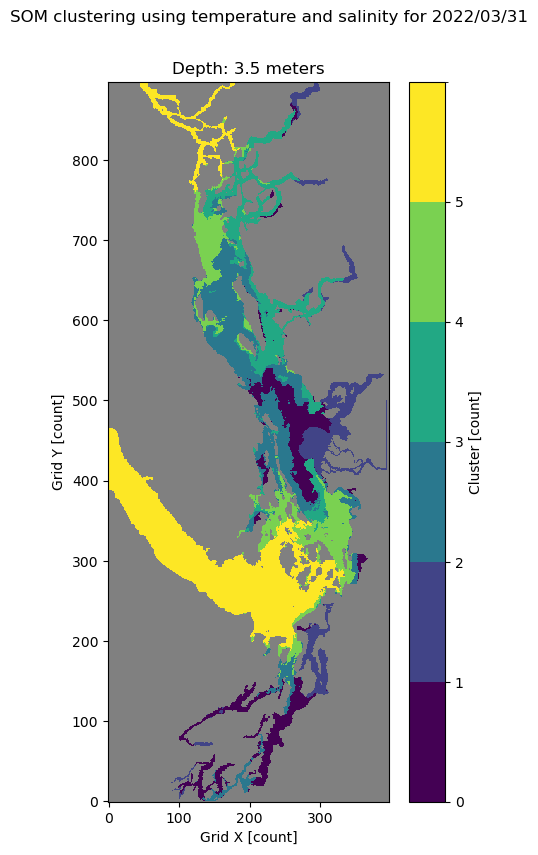

The amount of grid boxes for cluster 0 is 6785 

The minimum temperature for cluster 0 is 7.85 degrees Celsius
The maximum temperature for cluster 0 is 9.26 degrees Celsius
The mean temperature for cluster 0 is 8.23 degrees Celsius 

The minimum salinity for cluster 0 is 28.84 g/kg
The maximum salinity for cluster 0 is 30.65 g/kg
The mean salinity for cluster 0 is 29.25 g/kg 


The amount of grid boxes for cluster 1 is 23652 

The minimum temperature for cluster 1 is 6.67 degrees Celsius
The maximum temperature for cluster 1 is 8.5 degrees Celsius
The mean temperature for cluster 1 is 7.92 degrees Celsius 

The minimum salinity for cluster 1 is 28.84 g/kg
The maximum salinity for cluster 1 is 31.36 g/kg
The mean salinity for cluster 1 is 30.51 g/kg 


The amount of grid boxes for cluster 2 is 15224 

The minimum temperature for cluster 2 is 8.0 degrees Celsius
The maximum temperature for cluster 2 is 9.52 degrees Celsius
The mean temperature for cluster 2 is 8.47 degrees Celsius 

The 

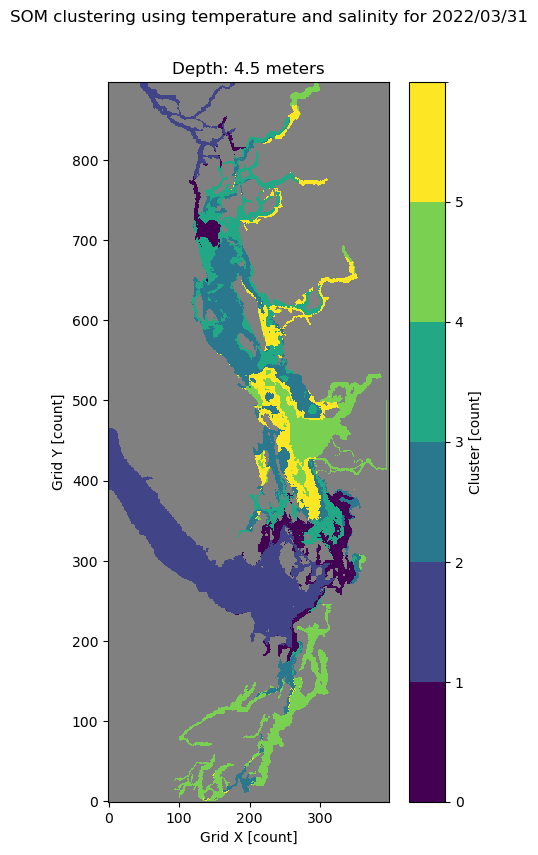

The amount of grid boxes for cluster 0 is 13428 

The minimum temperature for cluster 0 is 8.35 degrees Celsius
The maximum temperature for cluster 0 is 10.37 degrees Celsius
The mean temperature for cluster 0 is 8.87 degrees Celsius 

The minimum salinity for cluster 0 is 23.97 g/kg
The maximum salinity for cluster 0 is 29.23 g/kg
The mean salinity for cluster 0 is 27.12 g/kg 


The amount of grid boxes for cluster 1 is 4635 

The minimum temperature for cluster 1 is 6.25 degrees Celsius
The maximum temperature for cluster 1 is 9.39 degrees Celsius
The mean temperature for cluster 1 is 8.16 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 27.11 g/kg
The mean salinity for cluster 1 is 22.29 g/kg 


The amount of grid boxes for cluster 2 is 14566 

The minimum temperature for cluster 2 is 8.07 degrees Celsius
The maximum temperature for cluster 2 is 9.24 degrees Celsius
The mean temperature for cluster 2 is 8.34 degrees Celsius 

The

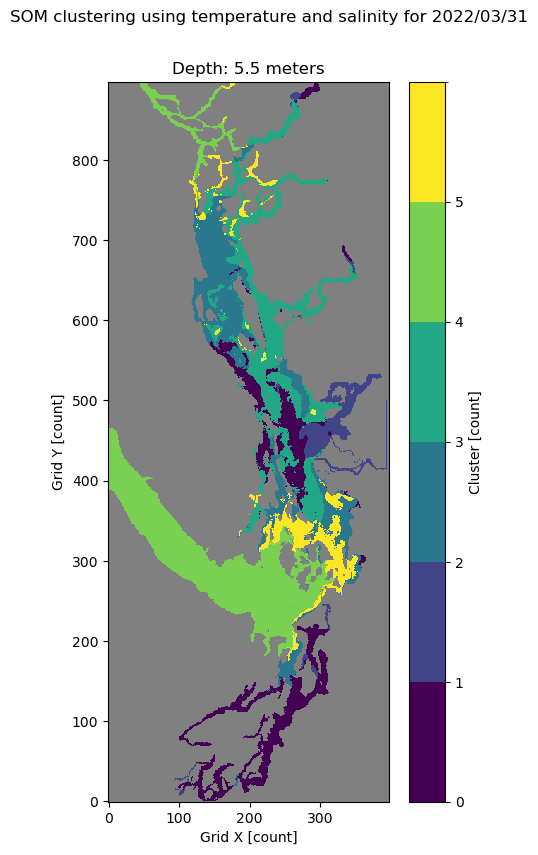

The amount of grid boxes for cluster 0 is 3654 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 9.23 degrees Celsius
The mean temperature for cluster 0 is 7.94 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 27.43 g/kg
The mean salinity for cluster 0 is 23.01 g/kg 


The amount of grid boxes for cluster 1 is 16701 

The minimum temperature for cluster 1 is 8.19 degrees Celsius
The maximum temperature for cluster 1 is 10.32 degrees Celsius
The mean temperature for cluster 1 is 8.7 degrees Celsius 

The minimum salinity for cluster 1 is 24.25 g/kg
The maximum salinity for cluster 1 is 29.85 g/kg
The mean salinity for cluster 1 is 27.52 g/kg 


The amount of grid boxes for cluster 2 is 14769 

The minimum temperature for cluster 2 is 7.3 degrees Celsius
The maximum temperature for cluster 2 is 8.26 degrees Celsius
The mean temperature for cluster 2 is 7.9 degrees Celsius 

The mi

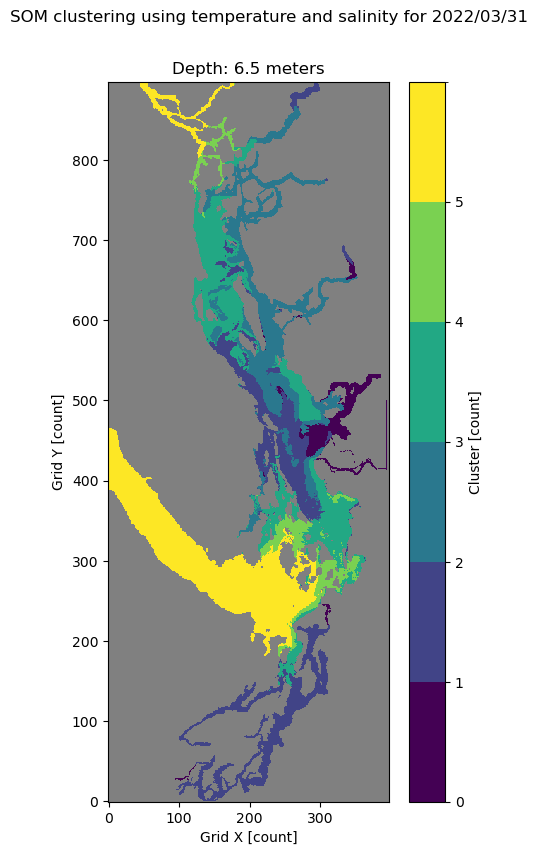

The amount of grid boxes for cluster 0 is 4037 

The minimum temperature for cluster 0 is 6.19 degrees Celsius
The maximum temperature for cluster 0 is 8.1 degrees Celsius
The mean temperature for cluster 0 is 7.85 degrees Celsius 

The minimum salinity for cluster 0 is 28.37 g/kg
The maximum salinity for cluster 0 is 30.01 g/kg
The mean salinity for cluster 0 is 29.42 g/kg 


The amount of grid boxes for cluster 1 is 22472 

The minimum temperature for cluster 1 is 7.4 degrees Celsius
The maximum temperature for cluster 1 is 8.63 degrees Celsius
The mean temperature for cluster 1 is 7.91 degrees Celsius 

The minimum salinity for cluster 1 is 29.55 g/kg
The maximum salinity for cluster 1 is 31.44 g/kg
The mean salinity for cluster 1 is 30.59 g/kg 


The amount of grid boxes for cluster 2 is 16927 

The minimum temperature for cluster 2 is 7.31 degrees Celsius
The maximum temperature for cluster 2 is 8.17 degrees Celsius
The mean temperature for cluster 2 is 7.89 degrees Celsius 

The 

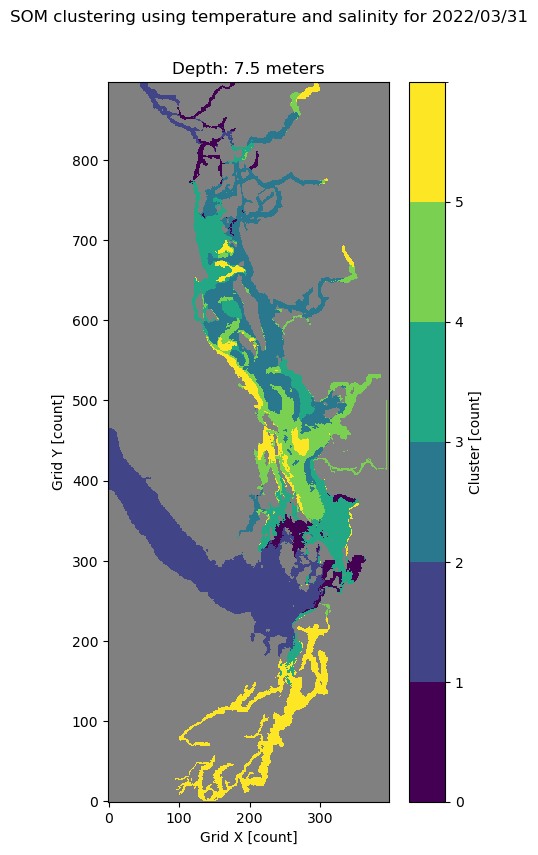

The amount of grid boxes for cluster 0 is 13843 

The minimum temperature for cluster 0 is 8.15 degrees Celsius
The maximum temperature for cluster 0 is 10.27 degrees Celsius
The mean temperature for cluster 0 is 8.66 degrees Celsius 

The minimum salinity for cluster 0 is 25.11 g/kg
The maximum salinity for cluster 0 is 29.41 g/kg
The mean salinity for cluster 0 is 27.93 g/kg 


The amount of grid boxes for cluster 1 is 2039 

The minimum temperature for cluster 1 is 6.25 degrees Celsius
The maximum temperature for cluster 1 is 9.21 degrees Celsius
The mean temperature for cluster 1 is 7.87 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 27.85 g/kg
The mean salinity for cluster 1 is 22.76 g/kg 


The amount of grid boxes for cluster 2 is 14436 

The minimum temperature for cluster 2 is 7.99 degrees Celsius
The maximum temperature for cluster 2 is 8.74 degrees Celsius
The mean temperature for cluster 2 is 8.19 degrees Celsius 

The

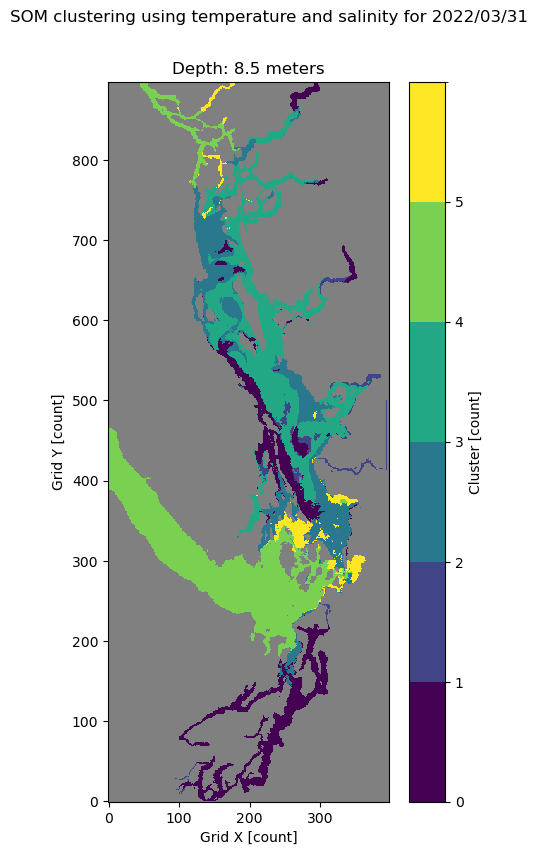

The amount of grid boxes for cluster 0 is 12013 

The minimum temperature for cluster 0 is 8.23 degrees Celsius
The maximum temperature for cluster 0 is 10.27 degrees Celsius
The mean temperature for cluster 0 is 8.71 degrees Celsius 

The minimum salinity for cluster 0 is 21.9 g/kg
The maximum salinity for cluster 0 is 29.83 g/kg
The mean salinity for cluster 0 is 28.1 g/kg 


The amount of grid boxes for cluster 1 is 6435 

The minimum temperature for cluster 1 is 6.25 degrees Celsius
The maximum temperature for cluster 1 is 9.03 degrees Celsius
The mean temperature for cluster 1 is 8.06 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 28.58 g/kg
The mean salinity for cluster 1 is 26.72 g/kg 


The amount of grid boxes for cluster 2 is 14005 

The minimum temperature for cluster 2 is 7.94 degrees Celsius
The maximum temperature for cluster 2 is 8.56 degrees Celsius
The mean temperature for cluster 2 is 8.15 degrees Celsius 

The m

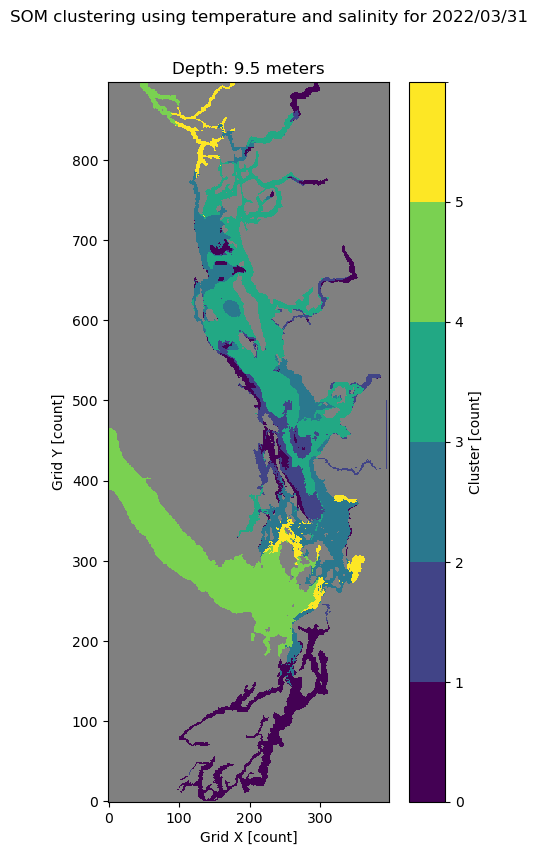

The amount of grid boxes for cluster 0 is 20057 

The minimum temperature for cluster 0 is 7.32 degrees Celsius
The maximum temperature for cluster 0 is 8.33 degrees Celsius
The mean temperature for cluster 0 is 7.87 degrees Celsius 

The minimum salinity for cluster 0 is 29.88 g/kg
The maximum salinity for cluster 0 is 31.56 g/kg
The mean salinity for cluster 0 is 30.72 g/kg 


The amount of grid boxes for cluster 1 is 4255 

The minimum temperature for cluster 1 is 6.22 degrees Celsius
The maximum temperature for cluster 1 is 8.04 degrees Celsius
The mean temperature for cluster 1 is 7.82 degrees Celsius 

The minimum salinity for cluster 1 is 29.12 g/kg
The maximum salinity for cluster 1 is 30.13 g/kg
The mean salinity for cluster 1 is 29.68 g/kg 


The amount of grid boxes for cluster 2 is 10486 

The minimum temperature for cluster 2 is 7.95 degrees Celsius
The maximum temperature for cluster 2 is 8.51 degrees Celsius
The mean temperature for cluster 2 is 8.14 degrees Celsius 

Th

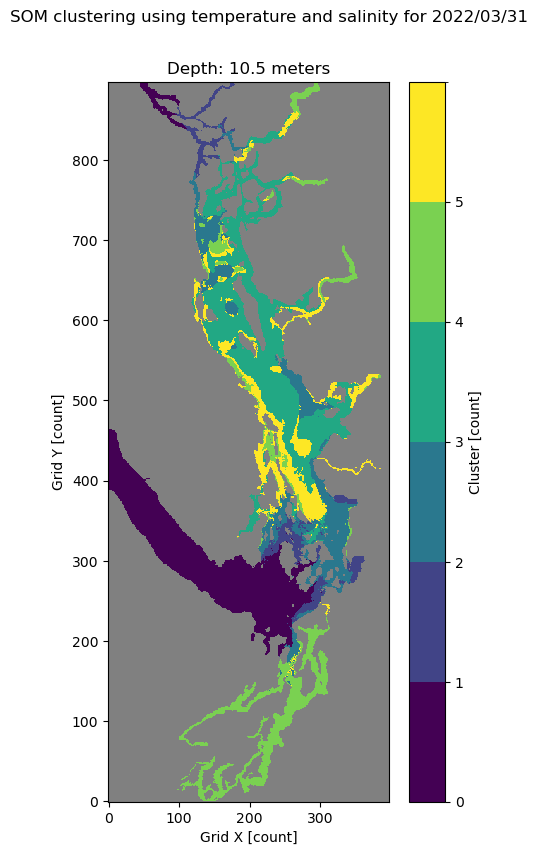

The amount of grid boxes for cluster 0 is 19524 

The minimum temperature for cluster 0 is 7.28 degrees Celsius
The maximum temperature for cluster 0 is 8.33 degrees Celsius
The mean temperature for cluster 0 is 7.86 degrees Celsius 

The minimum salinity for cluster 0 is 29.97 g/kg
The maximum salinity for cluster 0 is 31.61 g/kg
The mean salinity for cluster 0 is 30.75 g/kg 


The amount of grid boxes for cluster 1 is 3784 

The minimum temperature for cluster 1 is 6.32 degrees Celsius
The maximum temperature for cluster 1 is 8.02 degrees Celsius
The mean temperature for cluster 1 is 7.8 degrees Celsius 

The minimum salinity for cluster 1 is 29.25 g/kg
The maximum salinity for cluster 1 is 30.08 g/kg
The mean salinity for cluster 1 is 29.75 g/kg 


The amount of grid boxes for cluster 2 is 7500 

The minimum temperature for cluster 2 is 7.92 degrees Celsius
The maximum temperature for cluster 2 is 8.4 degrees Celsius
The mean temperature for cluster 2 is 8.07 degrees Celsius 

The m

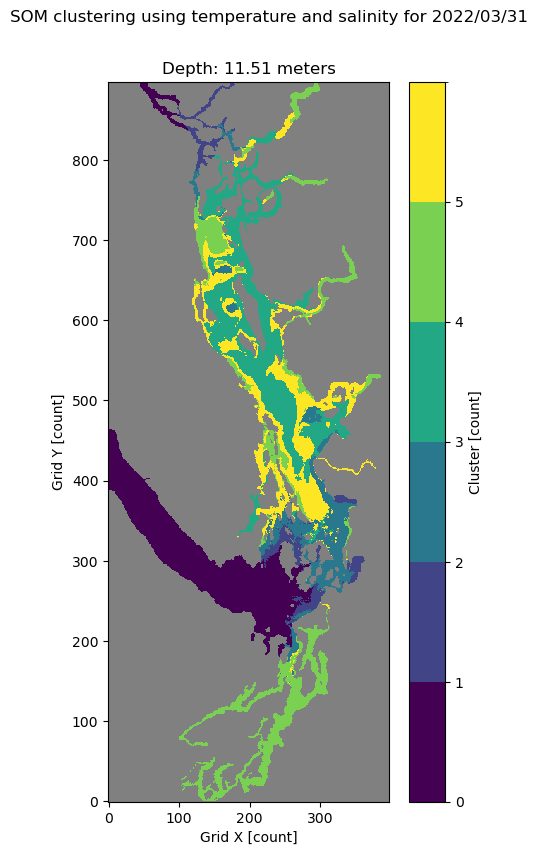

The amount of grid boxes for cluster 0 is 14376 

The minimum temperature for cluster 0 is 8.21 degrees Celsius
The maximum temperature for cluster 0 is 10.5 degrees Celsius
The mean temperature for cluster 0 is 8.64 degrees Celsius 

The minimum salinity for cluster 0 is 18.83 g/kg
The maximum salinity for cluster 0 is 29.86 g/kg
The mean salinity for cluster 0 is 28.52 g/kg 


The amount of grid boxes for cluster 1 is 16682 

The minimum temperature for cluster 1 is 6.41 degrees Celsius
The maximum temperature for cluster 1 is 8.22 degrees Celsius
The mean temperature for cluster 1 is 7.99 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 28.92 g/kg
The mean salinity for cluster 1 is 28.32 g/kg 


The amount of grid boxes for cluster 2 is 10110 

The minimum temperature for cluster 2 is 8.0 degrees Celsius
The maximum temperature for cluster 2 is 8.43 degrees Celsius
The mean temperature for cluster 2 is 8.13 degrees Celsius 

The 

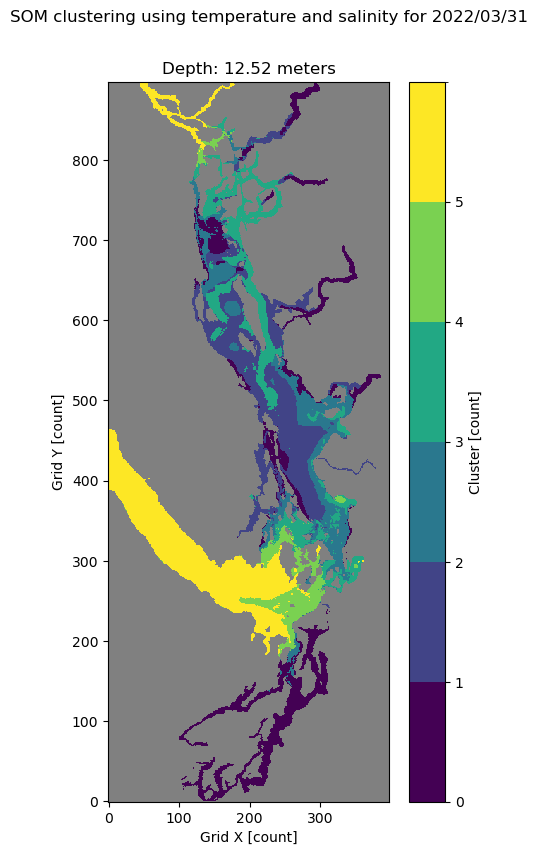

The amount of grid boxes for cluster 0 is 6632 

The minimum temperature for cluster 0 is 6.42 degrees Celsius
The maximum temperature for cluster 0 is 8.37 degrees Celsius
The mean temperature for cluster 0 is 8.18 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.14 g/kg
The mean salinity for cluster 0 is 28.11 g/kg 


The amount of grid boxes for cluster 1 is 9351 

The minimum temperature for cluster 1 is 8.36 degrees Celsius
The maximum temperature for cluster 1 is 10.53 degrees Celsius
The mean temperature for cluster 1 is 8.85 degrees Celsius 

The minimum salinity for cluster 1 is 19.02 g/kg
The maximum salinity for cluster 1 is 29.87 g/kg
The mean salinity for cluster 1 is 28.48 g/kg 


The amount of grid boxes for cluster 2 is 23293 

The minimum temperature for cluster 2 is 7.37 degrees Celsius
The maximum temperature for cluster 2 is 8.13 degrees Celsius
The mean temperature for cluster 2 is 7.91 degrees Celsius 

The 

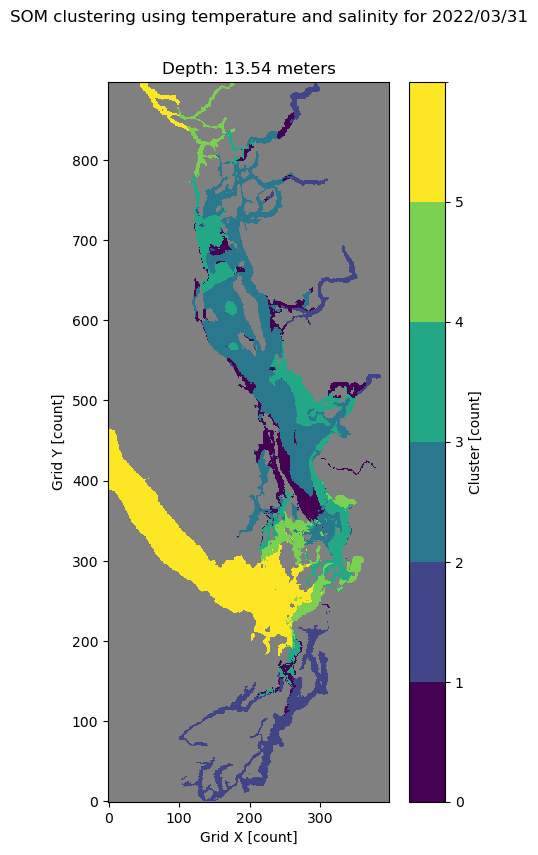

The amount of grid boxes for cluster 0 is 20435 

The minimum temperature for cluster 0 is 6.68 degrees Celsius
The maximum temperature for cluster 0 is 8.27 degrees Celsius
The mean temperature for cluster 0 is 7.82 degrees Celsius 

The minimum salinity for cluster 0 is 29.73 g/kg
The maximum salinity for cluster 0 is 31.73 g/kg
The mean salinity for cluster 0 is 30.75 g/kg 


The amount of grid boxes for cluster 1 is 4041 

The minimum temperature for cluster 1 is 7.53 degrees Celsius
The maximum temperature for cluster 1 is 8.06 degrees Celsius
The mean temperature for cluster 1 is 7.89 degrees Celsius 

The minimum salinity for cluster 1 is 29.13 g/kg
The maximum salinity for cluster 1 is 29.97 g/kg
The mean salinity for cluster 1 is 29.66 g/kg 


The amount of grid boxes for cluster 2 is 7052 

The minimum temperature for cluster 2 is 7.97 degrees Celsius
The maximum temperature for cluster 2 is 8.37 degrees Celsius
The mean temperature for cluster 2 is 8.08 degrees Celsius 

The

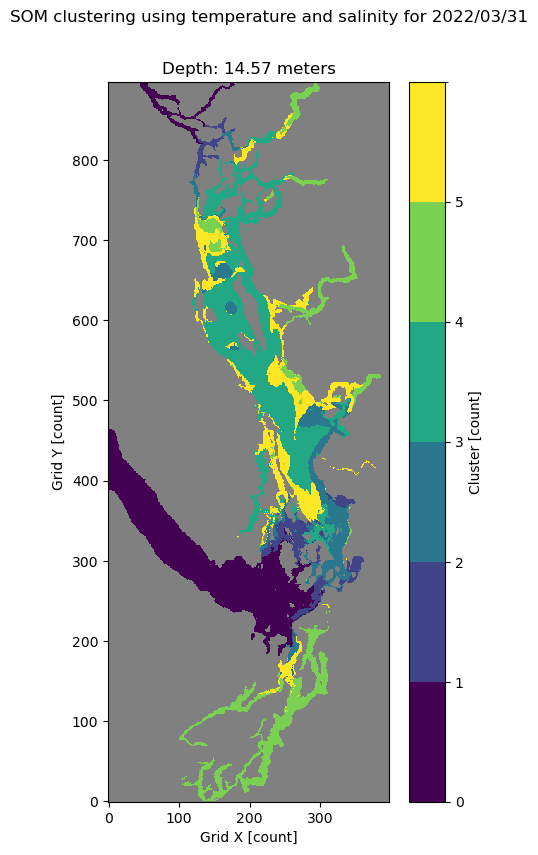

The amount of grid boxes for cluster 0 is 12923 

The minimum temperature for cluster 0 is 8.28 degrees Celsius
The maximum temperature for cluster 0 is 10.53 degrees Celsius
The mean temperature for cluster 0 is 8.74 degrees Celsius 

The minimum salinity for cluster 0 is 22.65 g/kg
The maximum salinity for cluster 0 is 29.88 g/kg
The mean salinity for cluster 0 is 28.81 g/kg 


The amount of grid boxes for cluster 1 is 5981 

The minimum temperature for cluster 1 is 6.42 degrees Celsius
The maximum temperature for cluster 1 is 8.53 degrees Celsius
The mean temperature for cluster 1 is 8.18 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 29.19 g/kg
The mean salinity for cluster 1 is 28.42 g/kg 


The amount of grid boxes for cluster 2 is 9357 

The minimum temperature for cluster 2 is 7.93 degrees Celsius
The maximum temperature for cluster 2 is 8.4 degrees Celsius
The mean temperature for cluster 2 is 8.1 degrees Celsius 

The mi

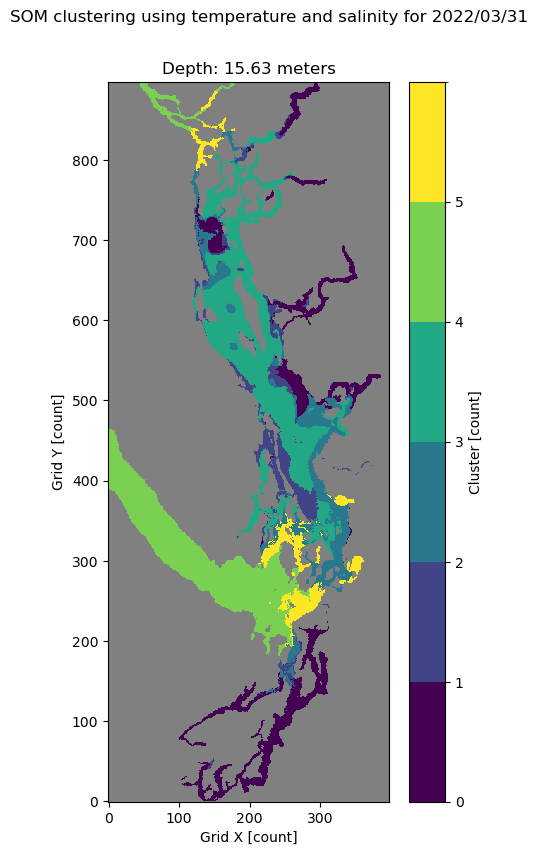

The amount of grid boxes for cluster 0 is 13119 

The minimum temperature for cluster 0 is 8.26 degrees Celsius
The maximum temperature for cluster 0 is 10.49 degrees Celsius
The mean temperature for cluster 0 is 8.75 degrees Celsius 

The minimum salinity for cluster 0 is 22.81 g/kg
The maximum salinity for cluster 0 is 29.89 g/kg
The mean salinity for cluster 0 is 28.88 g/kg 


The amount of grid boxes for cluster 1 is 3809 

The minimum temperature for cluster 1 is 6.48 degrees Celsius
The maximum temperature for cluster 1 is 8.87 degrees Celsius
The mean temperature for cluster 1 is 8.11 degrees Celsius 

The minimum salinity for cluster 1 is 0.0 g/kg
The maximum salinity for cluster 1 is 28.87 g/kg
The mean salinity for cluster 1 is 28.3 g/kg 


The amount of grid boxes for cluster 2 is 16363 

The minimum temperature for cluster 2 is 8.01 degrees Celsius
The maximum temperature for cluster 2 is 8.4 degrees Celsius
The mean temperature for cluster 2 is 8.12 degrees Celsius 

The m

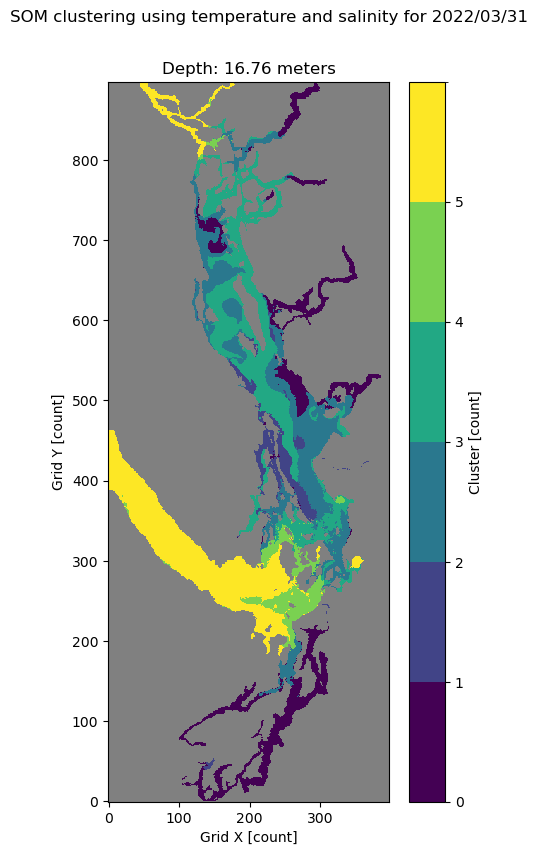

The amount of grid boxes for cluster 0 is 9391 

The minimum temperature for cluster 0 is 6.48 degrees Celsius
The maximum temperature for cluster 0 is 8.41 degrees Celsius
The mean temperature for cluster 0 is 8.26 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.67 g/kg
The mean salinity for cluster 0 is 29.03 g/kg 


The amount of grid boxes for cluster 1 is 10431 

The minimum temperature for cluster 1 is 8.38 degrees Celsius
The maximum temperature for cluster 1 is 10.42 degrees Celsius
The mean temperature for cluster 1 is 8.87 degrees Celsius 

The minimum salinity for cluster 1 is 20.39 g/kg
The maximum salinity for cluster 1 is 29.89 g/kg
The mean salinity for cluster 1 is 28.88 g/kg 


The amount of grid boxes for cluster 2 is 24121 

The minimum temperature for cluster 2 is 7.47 degrees Celsius
The maximum temperature for cluster 2 is 8.14 degrees Celsius
The mean temperature for cluster 2 is 7.95 degrees Celsius 

The

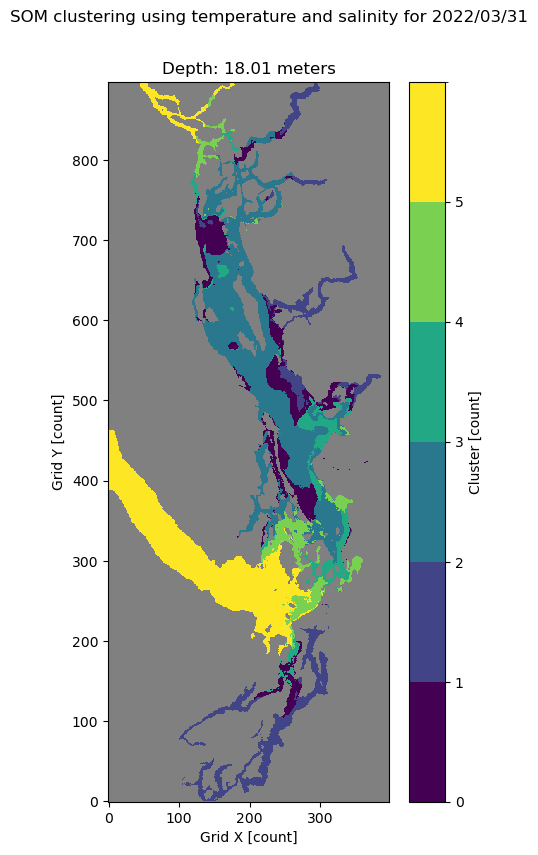

The amount of grid boxes for cluster 0 is 17431 

The minimum temperature for cluster 0 is 7.15 degrees Celsius
The maximum temperature for cluster 0 is 8.18 degrees Celsius
The mean temperature for cluster 0 is 7.77 degrees Celsius 

The minimum salinity for cluster 0 is 29.89 g/kg
The maximum salinity for cluster 0 is 31.97 g/kg
The mean salinity for cluster 0 is 30.93 g/kg 


The amount of grid boxes for cluster 1 is 5730 

The minimum temperature for cluster 1 is 7.34 degrees Celsius
The maximum temperature for cluster 1 is 8.02 degrees Celsius
The mean temperature for cluster 1 is 7.87 degrees Celsius 

The minimum salinity for cluster 1 is 28.4 g/kg
The maximum salinity for cluster 1 is 30.34 g/kg
The mean salinity for cluster 1 is 29.89 g/kg 


The amount of grid boxes for cluster 2 is 2781 

The minimum temperature for cluster 2 is 7.98 degrees Celsius
The maximum temperature for cluster 2 is 8.35 degrees Celsius
The mean temperature for cluster 2 is 8.1 degrees Celsius 

The m

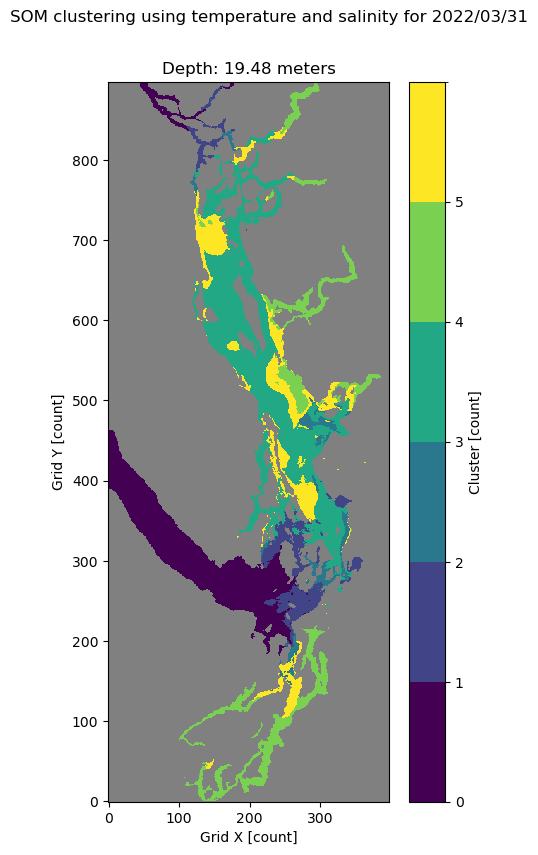

The amount of grid boxes for cluster 0 is 8066 

The minimum temperature for cluster 0 is 8.16 degrees Celsius
The maximum temperature for cluster 0 is 8.51 degrees Celsius
The mean temperature for cluster 0 is 8.3 degrees Celsius 

The minimum salinity for cluster 0 is 27.04 g/kg
The maximum salinity for cluster 0 is 29.87 g/kg
The mean salinity for cluster 0 is 29.18 g/kg 


The amount of grid boxes for cluster 1 is 10809 

The minimum temperature for cluster 1 is 8.45 degrees Celsius
The maximum temperature for cluster 1 is 10.23 degrees Celsius
The mean temperature for cluster 1 is 8.88 degrees Celsius 

The minimum salinity for cluster 1 is 23.37 g/kg
The maximum salinity for cluster 1 is 29.9 g/kg
The mean salinity for cluster 1 is 29.11 g/kg 


The amount of grid boxes for cluster 2 is 18886 

The minimum temperature for cluster 2 is 7.81 degrees Celsius
The maximum temperature for cluster 2 is 8.18 degrees Celsius
The mean temperature for cluster 2 is 8.04 degrees Celsius 

The

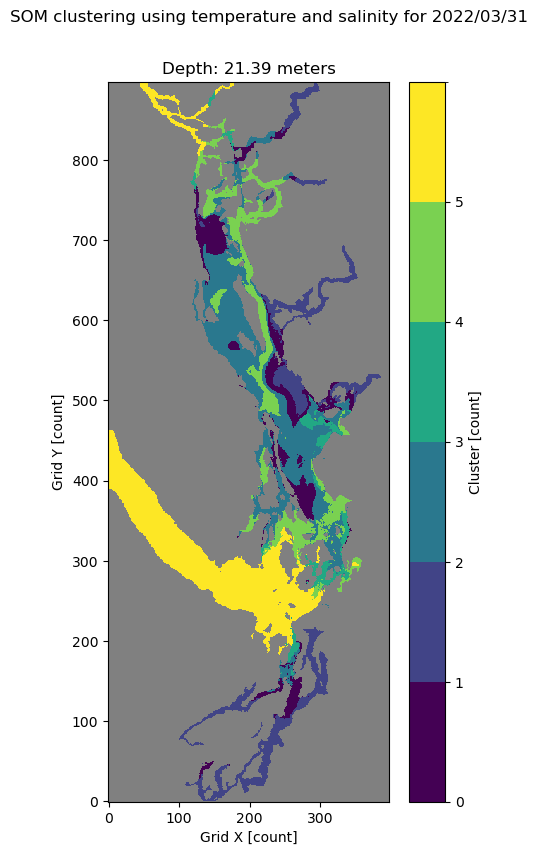

The amount of grid boxes for cluster 0 is 7983 

The minimum temperature for cluster 0 is 8.11 degrees Celsius
The maximum temperature for cluster 0 is 8.44 degrees Celsius
The mean temperature for cluster 0 is 8.26 degrees Celsius 

The minimum salinity for cluster 0 is 27.19 g/kg
The maximum salinity for cluster 0 is 29.86 g/kg
The mean salinity for cluster 0 is 29.22 g/kg 


The amount of grid boxes for cluster 1 is 12363 

The minimum temperature for cluster 1 is 8.43 degrees Celsius
The maximum temperature for cluster 1 is 10.2 degrees Celsius
The mean temperature for cluster 1 is 8.84 degrees Celsius 

The minimum salinity for cluster 1 is 26.4 g/kg
The maximum salinity for cluster 1 is 29.91 g/kg
The mean salinity for cluster 1 is 29.25 g/kg 


The amount of grid boxes for cluster 2 is 23884 

The minimum temperature for cluster 2 is 7.66 degrees Celsius
The maximum temperature for cluster 2 is 8.17 degrees Celsius
The mean temperature for cluster 2 is 8.0 degrees Celsius 

The 

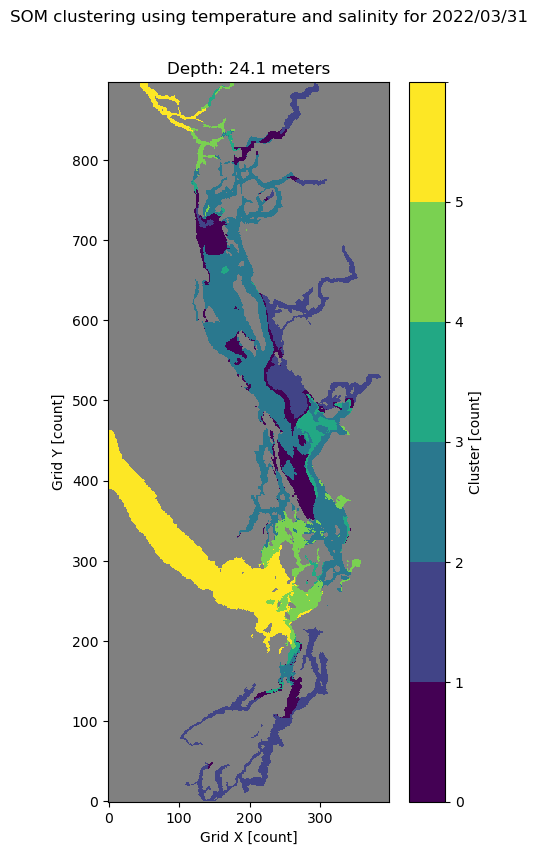

The amount of grid boxes for cluster 0 is 15679 

The minimum temperature for cluster 0 is 7.13 degrees Celsius
The maximum temperature for cluster 0 is 8.05 degrees Celsius
The mean temperature for cluster 0 is 7.7 degrees Celsius 

The minimum salinity for cluster 0 is 29.97 g/kg
The maximum salinity for cluster 0 is 32.44 g/kg
The mean salinity for cluster 0 is 31.15 g/kg 


The amount of grid boxes for cluster 1 is 5878 

The minimum temperature for cluster 1 is 7.34 degrees Celsius
The maximum temperature for cluster 1 is 8.01 degrees Celsius
The mean temperature for cluster 1 is 7.85 degrees Celsius 

The minimum salinity for cluster 1 is 28.42 g/kg
The maximum salinity for cluster 1 is 30.65 g/kg
The mean salinity for cluster 1 is 30.06 g/kg 


The amount of grid boxes for cluster 2 is 1131 

The minimum temperature for cluster 2 is 7.97 degrees Celsius
The maximum temperature for cluster 2 is 8.38 degrees Celsius
The mean temperature for cluster 2 is 8.14 degrees Celsius 

The 

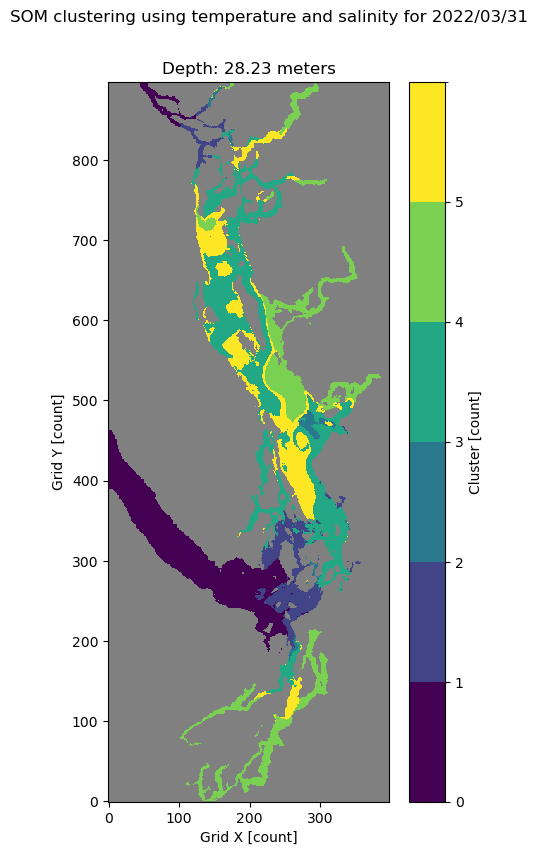

The amount of grid boxes for cluster 0 is 11509 

The minimum temperature for cluster 0 is 8.2 degrees Celsius
The maximum temperature for cluster 0 is 8.67 degrees Celsius
The mean temperature for cluster 0 is 8.36 degrees Celsius 

The minimum salinity for cluster 0 is 26.82 g/kg
The maximum salinity for cluster 0 is 30.22 g/kg
The mean salinity for cluster 0 is 29.34 g/kg 


The amount of grid boxes for cluster 1 is 10764 

The minimum temperature for cluster 1 is 8.46 degrees Celsius
The maximum temperature for cluster 1 is 10.21 degrees Celsius
The mean temperature for cluster 1 is 8.91 degrees Celsius 

The minimum salinity for cluster 1 is 27.31 g/kg
The maximum salinity for cluster 1 is 30.33 g/kg
The mean salinity for cluster 1 is 29.67 g/kg 


The amount of grid boxes for cluster 2 is 18201 

The minimum temperature for cluster 2 is 7.82 degrees Celsius
The maximum temperature for cluster 2 is 8.27 degrees Celsius
The mean temperature for cluster 2 is 8.12 degrees Celsius 

T

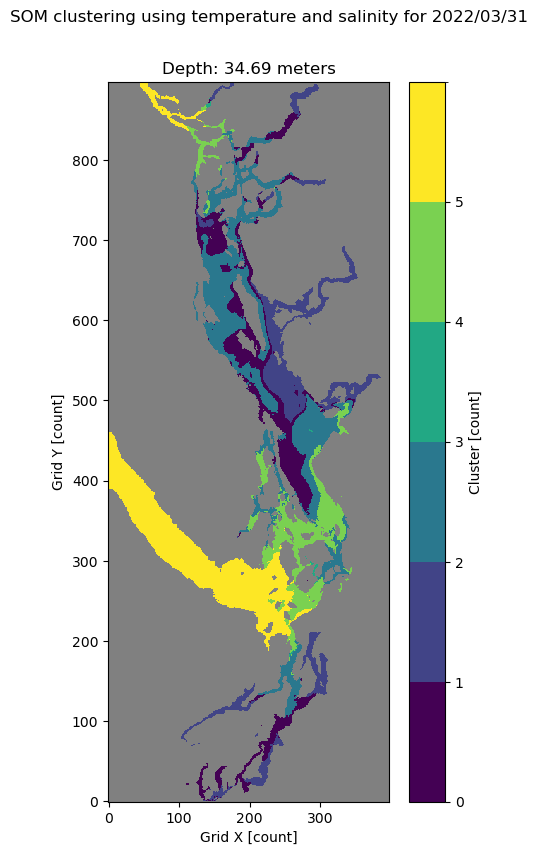

The amount of grid boxes for cluster 0 is 9301 

The minimum temperature for cluster 0 is 7.5 degrees Celsius
The maximum temperature for cluster 0 is 8.0 degrees Celsius
The mean temperature for cluster 0 is 7.84 degrees Celsius 

The minimum salinity for cluster 0 is 28.85 g/kg
The maximum salinity for cluster 0 is 30.81 g/kg
The mean salinity for cluster 0 is 29.96 g/kg 


The amount of grid boxes for cluster 1 is 14969 

The minimum temperature for cluster 1 is 7.13 degrees Celsius
The maximum temperature for cluster 1 is 7.8 degrees Celsius
The mean temperature for cluster 1 is 7.59 degrees Celsius 

The minimum salinity for cluster 1 is 30.0 g/kg
The maximum salinity for cluster 1 is 32.93 g/kg
The mean salinity for cluster 1 is 31.52 g/kg 


The amount of grid boxes for cluster 2 is 13634 

The minimum temperature for cluster 2 is 7.83 degrees Celsius
The maximum temperature for cluster 2 is 8.34 degrees Celsius
The mean temperature for cluster 2 is 8.15 degrees Celsius 

The mi

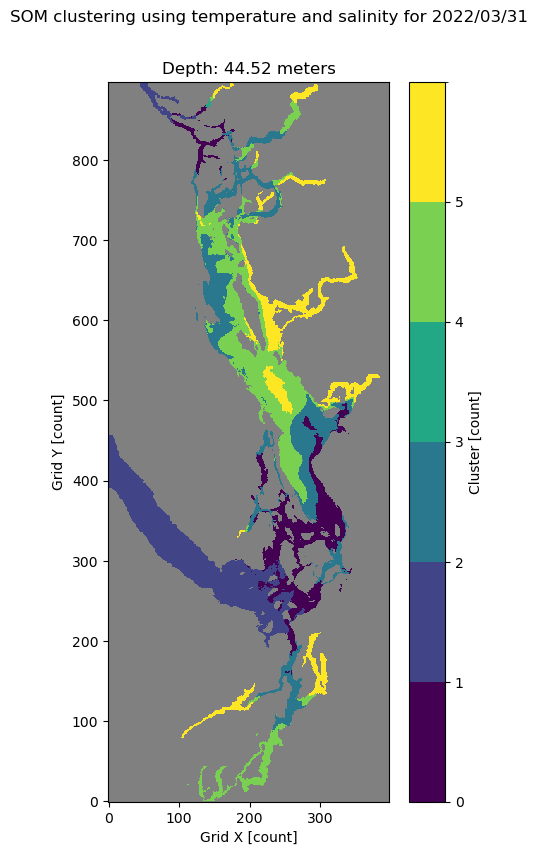

The amount of grid boxes for cluster 0 is 9425 

The minimum temperature for cluster 0 is 7.43 degrees Celsius
The maximum temperature for cluster 0 is 7.93 degrees Celsius
The mean temperature for cluster 0 is 7.77 degrees Celsius 

The minimum salinity for cluster 0 is 28.91 g/kg
The maximum salinity for cluster 0 is 31.21 g/kg
The mean salinity for cluster 0 is 30.25 g/kg 


The amount of grid boxes for cluster 1 is 12450 

The minimum temperature for cluster 1 is 7.15 degrees Celsius
The maximum temperature for cluster 1 is 7.71 degrees Celsius
The mean temperature for cluster 1 is 7.48 degrees Celsius 

The minimum salinity for cluster 1 is 30.81 g/kg
The maximum salinity for cluster 1 is 33.17 g/kg
The mean salinity for cluster 1 is 32.01 g/kg 


The amount of grid boxes for cluster 2 is 10435 

The minimum temperature for cluster 2 is 7.78 degrees Celsius
The maximum temperature for cluster 2 is 8.38 degrees Celsius
The mean temperature for cluster 2 is 8.12 degrees Celsius 

Th

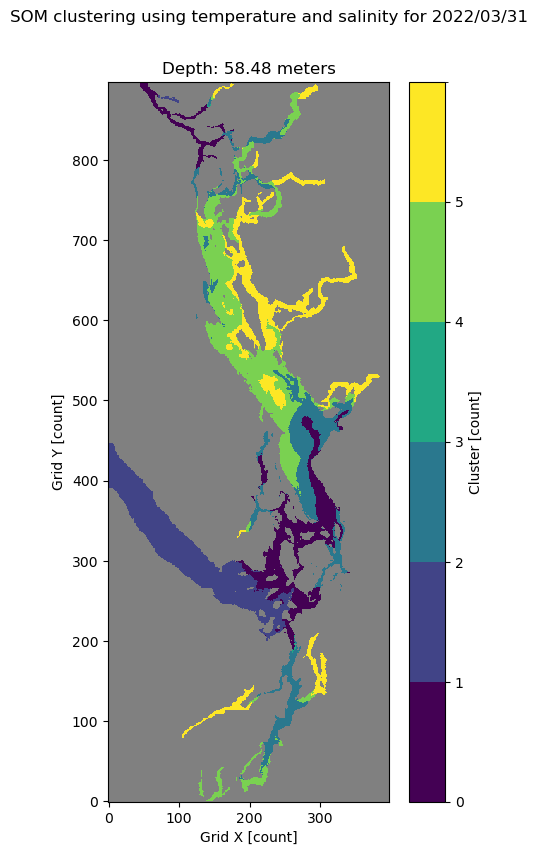

The amount of grid boxes for cluster 0 is 16438 

The minimum temperature for cluster 0 is 8.56 degrees Celsius
The maximum temperature for cluster 0 is 10.45 degrees Celsius
The mean temperature for cluster 0 is 8.86 degrees Celsius 

The minimum salinity for cluster 0 is 29.5 g/kg
The maximum salinity for cluster 0 is 30.53 g/kg
The mean salinity for cluster 0 is 30.04 g/kg 


The amount of grid boxes for cluster 1 is 8477 

The minimum temperature for cluster 1 is 8.22 degrees Celsius
The maximum temperature for cluster 1 is 8.62 degrees Celsius
The mean temperature for cluster 1 is 8.42 degrees Celsius 

The minimum salinity for cluster 1 is 27.51 g/kg
The maximum salinity for cluster 1 is 30.34 g/kg
The mean salinity for cluster 1 is 29.84 g/kg 


The amount of grid boxes for cluster 3 is 11610 

The minimum temperature for cluster 3 is 7.64 degrees Celsius
The maximum temperature for cluster 3 is 8.26 degrees Celsius
The mean temperature for cluster 3 is 7.97 degrees Celsius 

Th

IndexError: index 5 is out of bounds for axis 0 with size 5

In [14]:
ds, temp, saline, date, mask = datasets_preparation()

for depth in range (0, ds['deptht'].size+1):

    temp, saline = masking(depth, temp, saline, mask)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique)
